In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import torch
import torch.nn as nn
from torch.optim import RMSprop

In [58]:
data = pd.read_csv('../data/jhu-covid-cases.csv')
data = data[data.Province_State == 'Montana']
data = data[data.columns[11:]]
print(data.columns[:5])

death = pd.read_csv('../data/jhu-covid-deaths.csv')
death = death[death.Province_State == 'Montana']
death = death[death.columns[12:]]
print(death.columns[:5]) # make sure the dates match

data = np.array(data.sum(axis = 0)) #.reshape(-1, 1)
data = np.convolve(data, np.ones(7) / 7, 'valid')
data = torch.tensor(data)
Itilde = torch.log(1 + data[20:] - data[:-20]).reshape(1, -1)

death = torch.tensor(death.sum(axis = 0))
Dt = torch.tensor(np.convolve(death, np.ones(7) / 7, 'valid'))
Dtilde = torch.log(1 + Dt[:-20]).reshape(1, -1)

N = 1_123_000 # montana population 2022 (assume constant)
Ntilde = math.log(1 + N)

Stilde = torch.log(N - torch.exp(Itilde) - torch.exp(Dtilde))

print(Stilde.shape, Itilde.shape, Dtilde.shape) # make sure shapes match 

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20'], dtype='object')
Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20'], dtype='object')
torch.Size([1, 1117]) torch.Size([1, 1117]) torch.Size([1, 1117])


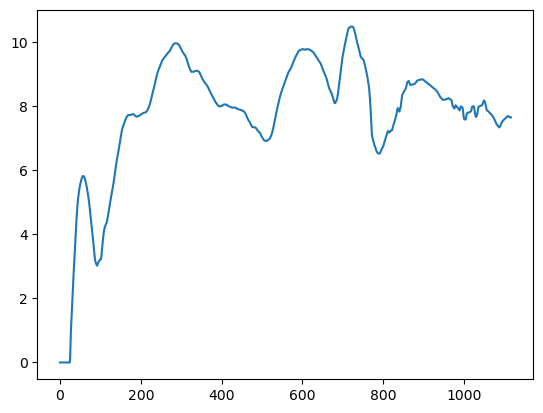

In [49]:
plt.plot(Itilde.ravel())

In [129]:
# don't use torch.gradient, instead use a very primitive euler scheme so the derivative/integral is consistent :)
Stilde_gradient = torch.zeros_like(Stilde)
Stilde_gradient = Stilde[:,1:] - Stilde[:,:-1]

Itilde_gradient = torch.zeros_like(Itilde)
Itilde_gradient = Itilde[:,1:] - Itilde[:,:-1]

Dtilde_gradient = torch.zeros_like(Dtilde)
Dtilde_gradient = Dtilde[:,1:] - Dtilde[:,:-1]

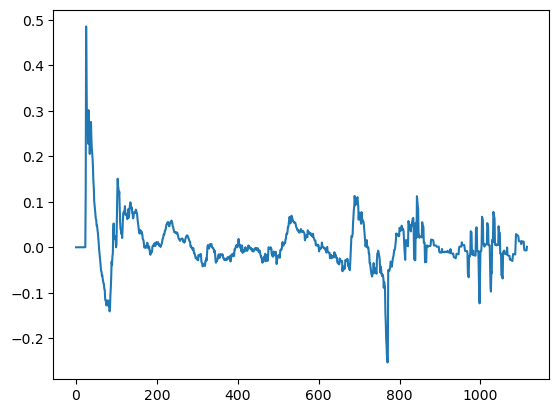

In [130]:
plt.plot(Itilde_gradient.ravel())

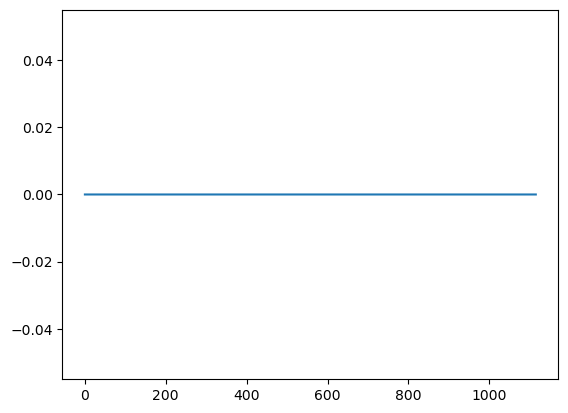

In [150]:
# should add up 
plt.plot(Itilde[:,1:].ravel() - (Itilde[0,0] + torch.cumsum(Itilde_gradient, dim = -1).ravel()))

In [460]:
# realistically, we should start at when there were sufficient cases in Montana (say > 50, or ln(50) = 1.7)
torch.arange(1117)[Itilde[0,:] > 1.7]

tensor([  30,   31,   32,  ..., 1114, 1115, 1116])

In [461]:
class Greeks(nn.Module): # put all 3 in 1
    def __init__(self, T = 1117 - 30):
        super().__init__()
        self.value_aux = nn.Parameter(torch.randn(3, T - 1))

    def forward(self):
        return torch.exp(self.value_aux)

    def second_derivative(self, index):
        x = self.forward()
        x = torch.gradient(x, dim = -1)[0] # first derivative
        x = torch.gradient(x, dim = -1)[0] # second derivative

        return x[:,:index]

    def __call__(self):
        return self.forward()

In [477]:
params = Greeks()

In [478]:
def train(params, step_size = 2):

    losses = []
    epoch = 0

    optimizer = RMSprop(params.parameters(), lr = 0.001)

    # initialize S, I, D to be whatever they really are :)
    Stilde_train = Stilde.clone()
    Itilde_train = Itilde.clone()
    Dtilde_train = Dtilde.clone()

    S0 = Stilde_train[0][0]
    I0 = Itilde_train[0][0]
    D0 = Dtilde_train[0][0]

    i = 1

    while 1 == 1:

        total_loss = 1e10

        top_index = i * step_size

        Stilde_train_i = Stilde_train[:,:top_index + 1]
        Itilde_train_i = Itilde_train[:,:top_index + 1]
        Dtilde_train_i = Dtilde_train[:,:top_index + 1]
    
        #while total_loss > 0.01:
        while epoch < 300 * top_index: 
            
            optimizer.zero_grad()
    
            beta = params()[0,:top_index]
            gamma = params()[1,:top_index]
            mu = params()[2,:top_index]

            # get partial derivatives
            dStilde_train = (gamma * torch.exp(Dtilde_train[:,:top_index] - Stilde_train[:,:top_index])) - \
            (beta * torch.exp(Itilde_train[:,:top_index] - Ntilde))
            dItilde_train = (beta * torch.exp(Stilde_train[:,:top_index] - Ntilde)) - \
            (mu * torch.exp(Dtilde_train[:,:top_index] - Itilde_train[:,:top_index])) - gamma
            dDtilde_train = mu * torch.exp(Itilde_train[:,:top_index] - Dtilde_train[:,:top_index])

            # assemble new Stilde,... from partial derivatives and initial conditions
            Saux = torch.ones_like(Stilde_train_i) * S0
            Iaux = torch.ones_like(Itilde_train_i) * I0
            Daux = torch.ones_like(Dtilde_train_i) * D0

            Sadd = torch.cumsum(dStilde_train, dim = -1)
            Saux[:,1:] += Sadd
            Iadd = torch.cumsum(dItilde_train, dim = -1)
            Iaux[:,1:] += Iadd
            Dadd = torch.cumsum(dDtilde_train, dim = -1)
            Daux[:,1:] += Dadd

            Stilde_train_i = Saux
            Itilde_train_i = Iaux
            Dtilde_train_i = Daux

            # losses for partials
            partial_loss = torch.mean((dStilde_train - Stilde_gradient[:,:top_index])**2) + \
            torch.mean((dItilde_train - Itilde_gradient[:,:top_index])**2) + torch.mean((dDtilde_train - Dtilde_gradient[:,:top_index])**2)

            # losses for integrated S, I, D values
            curve_loss = torch.mean((Dtilde_train[:,:top_index + 1] - Dtilde[:,:top_index + 1])**2) + \
            torch.mean((Itilde_train[:,:top_index + 1] - Itilde[:,:top_index + 1])**2) + \
            torch.mean((Stilde_train[:,:top_index + 1] - Stilde[:,:top_index + 1])**2)

            # smoothness loss
            smooth_loss = torch.mean(params.second_derivative(top_index)**2)
            
            # update and step
            total_loss = partial_loss + 10 * smooth_loss + curve_loss
            total_loss.backward()
            
            optimizer.step()
            
            if epoch % 20 == 0:
                print('=== Epoch:', epoch, '| Total loss:', total_loss.item(), '===') 
                #print(Itilde_train_i)
                
            losses.append(total_loss.item())
            epoch += 1

            # detach ground values
            Stilde_train_i = Stilde_train_i.detach()
            Itilde_train_i = Itilde_train_i.detach()
            Dtilde_train_i = Dtilde_train_i.detach()
    
        i += 1
        print('### SCALING UP ###')

        # update ground truths
        Stilde_train[:,:top_index + 1] = Stilde_train_i
        Itilde_train[:,:top_index + 1] = Itilde_train_i
        Dtilde_train[:,:top_index + 1] = Dtilde_train_i

        if top_index > 1117:
            break

    return losses


In [479]:
l = train(params)

=== Epoch: 0 | Total loss: 74.24238739350604 ===
=== Epoch: 20 | Total loss: 58.01289812225431 ===
=== Epoch: 40 | Total loss: 51.26511756684077 ===
=== Epoch: 60 | Total loss: 46.41845358749189 ===
=== Epoch: 80 | Total loss: 42.537149597825525 ===
=== Epoch: 100 | Total loss: 39.265725373735876 ===
=== Epoch: 120 | Total loss: 36.425245846803165 ===
=== Epoch: 140 | Total loss: 33.91126792275439 ===
=== Epoch: 160 | Total loss: 31.656704062404295 ===
=== Epoch: 180 | Total loss: 29.61532595636811 ===
=== Epoch: 200 | Total loss: 27.753456332166653 ===
=== Epoch: 220 | Total loss: 26.04529351520607 ===
=== Epoch: 240 | Total loss: 24.470260520730378 ===
=== Epoch: 260 | Total loss: 23.011154509577977 ===
=== Epoch: 280 | Total loss: 21.653173332132894 ===
=== Epoch: 300 | Total loss: 20.383317216861123 ===
=== Epoch: 320 | Total loss: 19.1902332449153 ===
=== Epoch: 340 | Total loss: 18.064054125047424 ===
=== Epoch: 360 | Total loss: 16.996774289679667 ===
=== Epoch: 380 | Total loss

KeyboardInterrupt: 

In [ ]:
plt.plot(l)

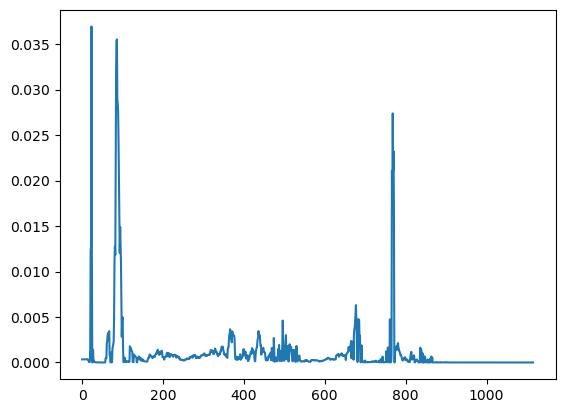

In [384]:
#plt.plot(params()[0].detach())
#plt.plot(params()[1].detach())
plt.plot(params()[2].detach())